[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scPCA/blob/main/docs/notebooks/kang.ipynb)

<div class="admonition note"> 
    <p class="admonition-title">Note</p>
    <p>In order to run this notebook in Google Colab run the following cells. For best performance make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.</p> 
</div>

In [3]:
# Install scPCA + dependencies
!pip install --quiet scpca scikit-misc

In [2]:
# Download the Kang et. al. dataset
!wget https://www.huber.embl.de/users/harald/sc/kang.h5ad /content/kang.h5ad

# Analysing interferon stimulated PBMCs using scPCA

In this notebook, we analyse the dataset from Kang et. al. in which the authors stimulated PBMCs with Interferon-$\beta$. We load the dataset using `scanpy`.

In [1]:
import scpca as scp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [2]:
data_path = '/content/kang.h5ad'
adata = sc.read_h5ad(data_path)

The canonical approach to analyse single-cell data involves to select highly variable genes followed by a logCPM transformation of the count data prior to PCA. Note that we save the original count data in the `layers` slot of the `adata` object, because `scPCA` operates on directly count data.

In [3]:
adata.layers["counts"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
sc.tl.pca(adata, n_comps=15)

We now generate a UMAP from PCA cell embeddings to obtain a visual overview of the dataset. The `scp.tl.umap` function first creates a nearest neighborhood graph and subsequently calculates UMAP coordinates.

In [6]:
scp.tl.umap(adata, 'X_pca')

Plotting the UMAPs reveals that although the PCA embeddings preserved the cellular identity within both conditions, they fail to align those properly within within UMAP space. This results in a separation of control and stimulated cells along the second UMAP axis (`X_pca_umap2`).

/home/voehring/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


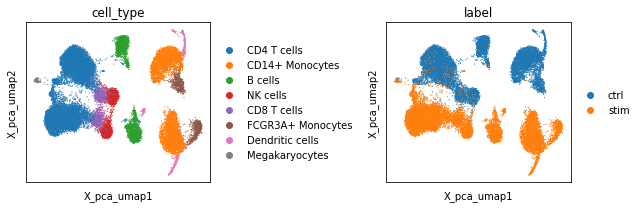

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_pca_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_pca_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

To understand why, we proceed by investigating the PCA factors. In particular, we plot the factor weights of the first few principal components using the `scc.pl.factor_embedding` function on top of the UMAP coordinates. Visual inspection indicates that the first factor (`Factor 0`) is likely to represent an axis of variation that delineates CD14+/FCGR3A+ monocytes and dendritic cells from all other cell types within the dataset. The second principal component (`Factor 1`) however seems to separate the cells by condition, i.e. whether the cell origins from the control or stimulated experiment.

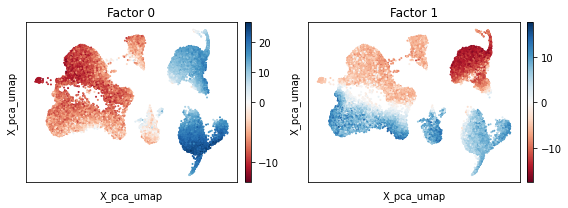

In [8]:
scp.pl.factor_embedding(adata, 'pca', [0, 1], width=4, height=3)
plt.tight_layout()

While the separation of cells across conditions is expected, it poses potential problems for further downstream analyses. Clustering by cell type, for example, is difficult due to the presence of factor 1 which separates same cell types by condition. For this reason, it is desirebable to account for the experimental condition while performing the dimensionality reduction. In `scPCA`, we inform the model about the experimental condition of each cell by employing design matrices. To understand how, we consider in this tutorial the usage of different design matrices, and explore how these affect `scPCA`'s cell embeddings.


## Recovering PCA, i.e. providing no information about the condition

To recover results that are similar to the PCA baseline, we provide two non-informative rank one matrices $D_1, B_1$ full of ones (depicted as black squares) as loading and intercept design matrix, respectively.

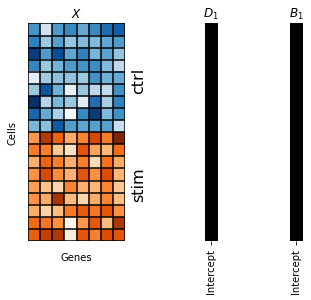

In [94]:
fig, axes = plt.subplots(1, 3, width_ratios=[0.5, 0.2, 0.2])
scp.pl.data_matrix(num_rows=18, num_cols=8, num_states=2, cmaps=['Blues', 'Oranges'], remove_ticklabels=True, xlabel='Genes', ylabel='Cells', title='$X$', ax=axes[0])
axes[0].text(8, 5, 'ctrl', rotation=90, fontsize=16)
axes[0].text(8, 14, 'stim', rotation=90, fontsize=16)
scp.pl.design_matrix(adata, '1', title='$D_1$', repeats=18, ax=axes[1])
scp.pl.design_matrix(adata, '1', title='$B_1$', repeats=18, ax=axes[2])

To instantiate such a model, we call the `scp.scPCA` constructor and provide the `anndata` object containing our data, the number of factors to extract and R-style formulas for the loadings (`loadings_formula`) and intercept (`intercept_formula`) design matrices. The `scPCA` constructor returns a model object with a `.fit()` method which by default trains the model aggressively with a learning rate of `lr=0.01` for 5000 training steps. Further training steps at a lower learning are often beneficial and may be added by calling the `.fit` method for a second time.

In [10]:
m0 = scp.scPCA(
    adata, 
    num_factors=15, 
    layers_key='counts', 
    loadings_formula='1', 
    intercept_formula='1', 
    seed=13516  # set seed for reproducibility
)

In [11]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/g/huber/users/voehring/opt/scPCA/scpca/models/scpca.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 7763468 | Δ_10: -197368.00 | Best: 7546310: 100%|██████████| 5000/5000 [03:12<00:00, 25.95it/s] 


In [12]:
m0.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7727032 | Δ_10: -40.50 | Best: 7477131: 100%|██████████| 2000/2000 [01:14<00:00, 26.80it/s]    


To obtain the results, we invoke the `.mean_to_anndata` function which computes the posterior mean of fitted parameters and stores them to the `anndata` object. Specifying `model_key` adds a prefix to the added keys such that a single `anndata` object may contain the fitted parameters of multiple `scPCA` models. Also, note the arguments `num_samples` and `num_split` which allow to specify the number of posterior samples and the number of observations that are sampled during a single batch of samples (here we set the number of posterior samples and number of observations per batch deliberately to 10 and 512 to avoid memory issues when the notebook is run in Google Colab).

In [13]:
m0.mean_to_anndata(model_key='m0', num_samples=10, num_split=512)

Predicting z for obs 24576-24672.: 100%|██████████| 49/49 [00:03<00:00, 14.26it/s]


By default, following variables are saved to the `anndata` object

* Model metadata: `adata.uns[f'{model_key}']` 
* Factor weights ($\mathbf{Z}$): `adata.obsm[f"X_{model_key}"]`
* Loading tensor weights ($\mathbf{W}$): `adata.varm[f"W_{model_key}"]`

In addition, by supplying via the `variables` argument the names

* Intercept weights ($\mathbf{V}$): `adata.varm[f"V_{model_key}"]`
* Predicted counts ($\boldsymbol{\mu}$): `adata.layers[f"μ_{model_key}"]` 

In [14]:
adata 

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'multiplets', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'ident'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'log1p', 'pca', 'X_pca', 'umap', 'cell_type_colors', 'label_colors', 'm0'
    obsm: 'X_pca', 'X_pca_umap', 'X_m0'
    varm: 'PCs', 'W_m0'
    layers: 'logcounts', 'counts'
    obsp: 'X_pca_distances', 'X_pca_connectivities'

We next compute a UMAP visualization on the embeddings of `m0`.

In [15]:
scp.tl.umap(adata, 'X_m0')

/home/voehring/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


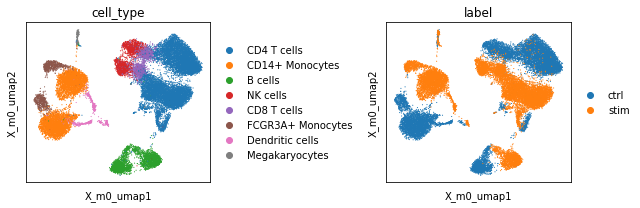

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m0_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m0_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

We find that the UMAP plot from `scPCA` cell embedding looks similar to the one which was based on PCA. We again inspect the factors to obtain a better understanding about the captured "principal axis" of variation (strictly speaking `scPCA` does not extract the principal axes of the data as it employs a non-isotropic noise model). Similar to PCA, we find a factor that seemingly delineates monocytes and dendritic cells (negative weights) from all other cells (positive weights, factor 0). The model also captured a factor that seemingly explains differences between the control (postive weights) and stimulated (negative weights) condition (Factor 1).

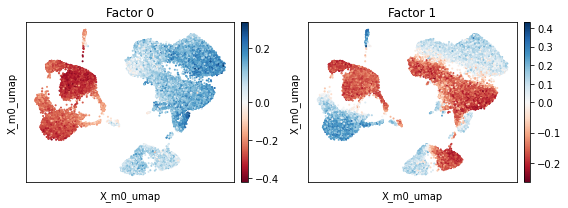

In [17]:
scp.pl.factor_embedding(adata, model_key='m0', basis='X_m0_umap', factor=[0, 1], width=4, height=3)
plt.tight_layout()

## Accounting for mean offsets using an intercept design matrix

As a first step we try to account for potential shifts in mean gene expression across conditions. Evidence for such shifts may be obtained by exploring how the number of total counts per cell differ between experimental condition.

In [18]:
adata.obs['label'] = pd.Categorical(adata.obs['label'], categories=['ctrl', 'stim'], ordered=True)
adata.obs['total_counts'] = np.asarray(adata.layers['counts'].sum(1)).reshape(-1)

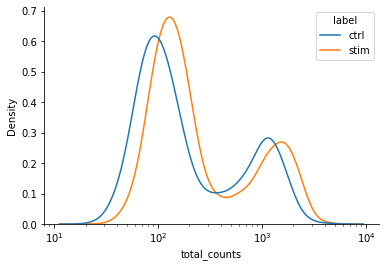

In [19]:
sns.kdeplot(x='total_counts', hue='label', data=adata.obs, log_scale=True)
sns.despine()

We find that cells from the stimulated condition tend to have a larger number of counts. To instruct the model to fit different means for both conditions, we consider the intercept design matrix $B_2$ which we may create by using the R-style formula `label-1` (see also https://patsy.readthedocs.io/en/latest/).

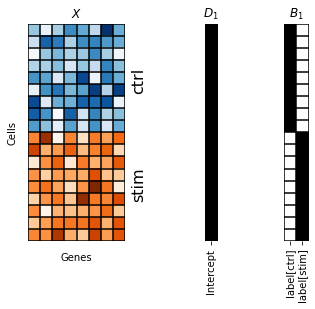

In [93]:
fig, axes = plt.subplots(1, 3, width_ratios=[0.5, 0.2, 0.2])
scp.pl.data_matrix(num_rows=18, num_cols=8, num_states=2, cmaps=['Blues', 'Oranges'], remove_ticklabels=True, xlabel='Genes', ylabel='Cells', title='$X$', ax=axes[0])
axes[0].text(8, 5, 'ctrl', rotation=90, fontsize=16)
axes[0].text(8, 14, 'stim', rotation=90, fontsize=16)
scp.pl.design_matrix(adata, '1', title='$D_1$', repeats=18, ax=axes[1])
scp.pl.design_matrix(adata[adata.obs.sort_values(by='label').index], 'label-1', title='$B_1$', repeats=9, columns=[1,0], ax=axes[2])

In [21]:
m1 = scp.scPCA(
    adata, 
    num_factors=15, 
    layers_key='counts', 
    loadings_formula='1', 
    intercept_formula='label-1',
    seed=352476 # seed for reproducibility
)

In [22]:
m1.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7763294 | Δ_10: -161069.00 | Best: 7631470: 100%|██████████| 5000/5000 [03:06<00:00, 26.87it/s] 


In [23]:
m1.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7717444 | Δ_10: 30755.50 | Best: 7546964: 100%|██████████| 2000/2000 [01:15<00:00, 26.46it/s]  


In [24]:
m1.mean_to_anndata(model_key='m1', num_samples=10, num_split=512)

Predicting z for obs 24576-24672.: 100%|██████████| 49/49 [00:03<00:00, 13.61it/s]


As before we proceed by computing an UMAP to observe the information captured by the factors. 

In [25]:
scp.tl.umap(adata, 'X_m1')

/home/voehring/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


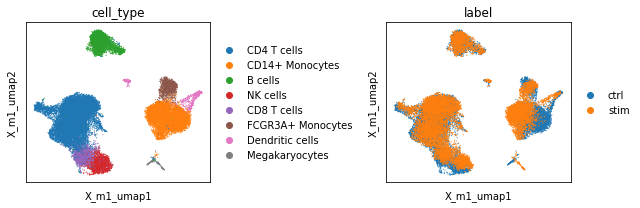

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m1_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m1_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

Strikingly, we observe that accounting for mean expression across coditions improves mixing across conditions substantially whilst preserving the identity of cells. Inspection of factors reveals the absence of a factor that clearly delineates the experimental condition.

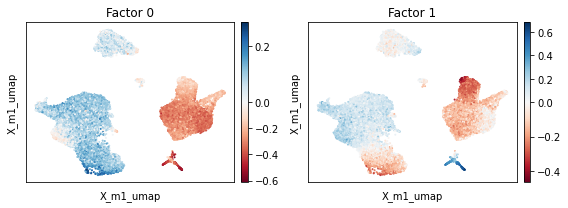

In [27]:
scp.pl.factor_embedding(adata, model_key='m1', basis='X_m1_umap', factor=[0, 1], width=4, height=3)
plt.tight_layout()

## Accounting for spectral shifts across conditions using a loading design matrix

Note that mixing of cells across conditions worked for all cell types except CD14+ monocytes which still clearly separate by condition. We next consider a model that specifies the design matrices $D_2$ and $B_2$.

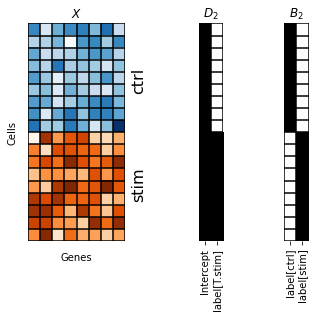

In [90]:
fig, axes = plt.subplots(1, 3, width_ratios=[0.5, 0.2, 0.2])
scp.pl.data_matrix(num_rows=18, num_cols=8, num_states=2, cmaps=['Blues', 'Oranges'], remove_ticklabels=True, xlabel='Genes', ylabel='Cells', title='$X$', ax=axes[0])
axes[0].text(8, 5, 'ctrl', rotation=90, fontsize=16)
axes[0].text(8, 14, 'stim', rotation=90, fontsize=16)
scp.pl.design_matrix(adata, 'label', title='$D_2$', repeats=9, ax=axes[1])
scp.pl.design_matrix(adata[adata.obs.sort_values(by='label').index], 'label-1', title='$B_2$', repeats=9, columns=[1,0], ax=axes[2])

Note that although both matrices have a column rank of two, $B_2$ exhibits a different structure from $D_2$. Particularly, $D_2$ contains a "intercept" column full of ones and an additional column in which cells from the control and stimulated conditions are marked with zeros and ones, respectively. This design matrix instructs the model to fit a set of basis vectors to the control condition and a separate set basis vectors to the stimulated condition. Importantly, the "intercept" column of $D_2$ introduces dependency between both bases, i.e. the bases for stimulated cells is expressed in terms of the basis vectors of the control.

In [50]:
m2 = scp.scPCA(
    adata, 
    num_factors=15,
    layers_key='counts',
    loadings_formula='label',
    intercept_formula='label-1',
    seed=8999074
)

In [51]:
m2.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7843832 | Δ_10: -71496.50 | Best: 7600418: 100%|██████████| 5000/5000 [03:11<00:00, 26.12it/s]  


In [52]:
m2.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7791184 | Δ_10: -8668.50 | Best: 7514048: 100%|██████████| 2000/2000 [01:17<00:00, 25.70it/s]  


In [53]:
m2.mean_to_anndata(model_key='m2', num_samples=10, num_split=512)

Predicting z for obs 24576-24672.: 100%|██████████| 49/49 [00:03<00:00, 13.47it/s]


Visual inspection of the UMAP suggests finally good mixing of the full dataset including CD14+ monocytes.

In [54]:
scp.tl.umap(adata, 'X_m2')

/home/voehring/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


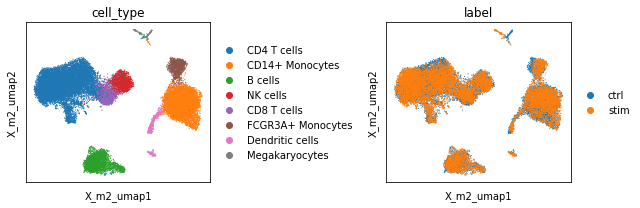

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m2_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m2_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

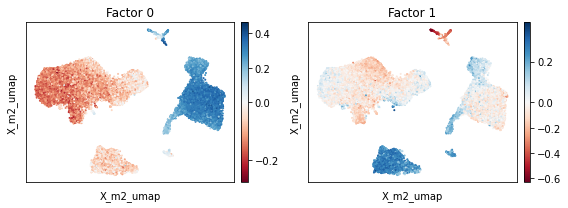

In [57]:
scp.pl.factor_embedding(adata, model_key='m2', basis='X_m2_umap',  factor=[0, 1], width=4, height=3)
plt.tight_layout()

Inspecting the factors suggests that Factor 0 constitutes particular large factor weights in CD14+ monocytes. To understand how the expression spectrum along this factor changed, we now investigate it's corresponding loading weights. These represent expression shifts relative to the mean expression in the corresponding condition condition. We may visualize these shifts using the `scp.pl.loadings_state` function which plots the loading weights of two states against each other. The function takes as an input the `anndata` object containing the model parameters, the `model_key`, and the states (conditions) and factor(s) to visualise. In the following plot, we show the top 10 upregulated genes in the interferon stimulated condition with respect to the control.

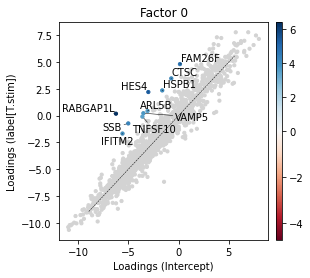

In [59]:
_ = scp.pl.loadings_state(adata, 'm2', ['Intercept', 'label[T.stim]'], 0, highest=10, width=4, height=4)

<div class="admonition note"> 
    <p class="admonition-title">Note</p> 
    <p>The state names are saved in adata.uns['{model_key}']['design'].</p>
</div>

Likewise we can investigate the downregulated genes by setting `lowest` to greater than 1.

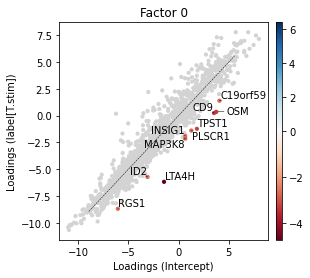

In [95]:
_ = scp.pl.loadings_state(
    adata, 
    model_key='m2', 
    states=['Intercept', 'label[T.stim]'], 
    factor=0,
    lowest=10, 
    width=4, 
    height=4
)

We can retrieve these genes using `scp.tl.state_diff` function which returns a `pd.DataFrame` containing the genes with the largest loading differences.

In [62]:
scp.tl.state_diff(
    adata, 
    model_key='m2', 
    states=['Intercept', 'label[T.stim]'], 
    factor=0
)

,gene,magnitude,difference,type,state,factor,index,Intercept,label[T.stim],significant
0,RABGAP1L,6.417222,6.417222,highest,label[T.stim]-Intercept,0,156,-6.237141,0.180081,True
1,HES4,5.216278,5.216278,highest,label[T.stim]-Intercept,0,0,-3.016278,2.200000,True
2,FAM26F,4.671150,4.671150,highest,label[T.stim]-Intercept,0,718,0.133603,4.804753,True
3,SSB,4.284873,4.284873,highest,label[T.stim]-Intercept,0,297,-5.013611,-0.728738,True
4,CTSC,4.198810,4.198810,highest,label[T.stim]-Intercept,0,1241,-0.729123,3.469687,True
5,HSPB1,3.979339,3.979339,highest,label[T.stim]-Intercept,0,795,-1.629695,2.349644,True
6,IFITM2,3.912938,3.912938,highest,label[T.stim]-Intercept,0,1160,-5.585498,-1.672560,True
7,VAMP5,3.727727,3.727727,highest,label[T.stim]-Intercept,0,252,-3.506615,0.221112,True
8,ARL5B,3.521853,3.521853,highest,label[T.stim]-Intercept,0,1081,-3.092183,0.429670,True
9,TNFSF10,3.508622,3.508622,highest,label[T.stim]-Intercept,0,433,-3.602018,-0.093397,True


<div class="admonition important"> <p>Note that factor models retrieve global axes of variation from data. While it is true that these often indicate features (i.e. genes) it is important double check these with the data.</p> </div>

In [65]:
var_dic = { 
    'up in stim CD14+ monocytes': scp.tl.state_diff(adata, 'm2', 'label[T.stim]', 0).gene.tolist(),
    'down in stim CD14+ monocytes': scp.tl.state_diff(adata, 'm2', 'label[T.stim]', 0, highest=0, lowest=10).gene.tolist(),
}

2023-10-11 08:08:49,133 - Only one state was provided, using 'Intercept' as base state.
2023-10-11 08:08:49,137 - Only one state was provided, using 'Intercept' as base state.


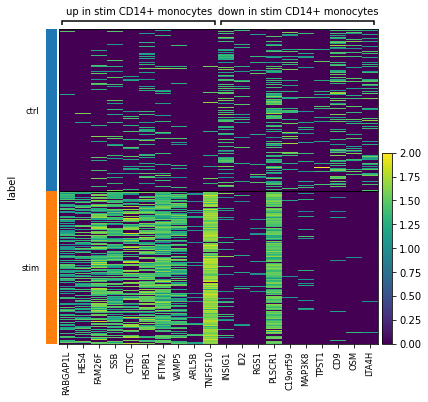

In [67]:
sc.pl.heatmap(adata[adata.obs.cell_type == 'CD14+ Monocytes'], var_names=var_dic, groupby='label', var_group_rotation=0, log=True)